## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/vision/stable/transforms.html

## Libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import classification_report

# Tracking progress
from tqdm import tqdm

# Set Seed
torch.manual_seed(2021)

plt.ion()   # interactive mode

## Load Data

In [62]:
# Just normalization for validation
data_transforms = {
    'mini': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/ubuntu/data/2A_images_reorg'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['mini', 'val', 'test']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['mini', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['mini', 'val', 'test']}
class_names = image_datasets['mini'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
print(dataset_sizes)
print(class_names)

{'mini': 10000, 'val': 19492, 'test': 19492}
['Covid', 'Normal', 'Pneumonia']


## Sample Image

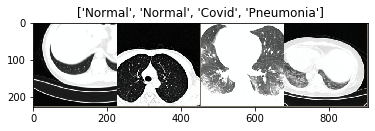

In [4]:
def imshow(inp, title=None):   
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['mini']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Function

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'epoch':[],'train_loss':[],'train_acc':[],"val_loss":[],'val_acc':[]}

    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        history['epoch'].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['mini', 'val']:
            if phase == 'mini':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'mini'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'mini':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'mini':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # store statistics
            if phase == 'mini':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Visual Model Predictions

In [6]:
def visualize_model(model, num_images=6, pred_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    eval_history = {'predict':[], 'actual':[]}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('(pred,actual): ({0},{1},{2})'.\
                                 format(class_names[preds[j]], 
                                        class_names[labels[j]]),
                                        prob[0][preds[j]].item())
                    imshow(inputs.cpu().data[j])

                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                
                elif images_so_far < pred_images:
                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                    
                elif images_so_far == pred_images:
                    model.train(mode=was_training)
                    return eval_history
        model.train(mode=was_training)

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [7]:
# lLad pretratined model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Reset final fully connected layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Model to GPU
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
#models.resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train and evaluate
Takes about 15 minutes for 10 epochs

In [26]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
mini Loss: 0.1152 Acc: 0.9613


  7%|▋         | 1/15 [01:35<22:23, 95.95s/it]

val Loss: 0.0537 Acc: 0.9826

Epoch 1/14
----------
mini Loss: 0.1183 Acc: 0.9600


 13%|█▎        | 2/15 [03:11<20:46, 95.92s/it]

val Loss: 0.0491 Acc: 0.9842

Epoch 2/14
----------
mini Loss: 0.1144 Acc: 0.9610


 20%|██        | 3/15 [04:48<19:14, 96.17s/it]

val Loss: 0.0491 Acc: 0.9848

Epoch 3/14
----------
mini Loss: 0.1044 Acc: 0.9651


 27%|██▋       | 4/15 [06:25<17:39, 96.30s/it]

val Loss: 0.0497 Acc: 0.9848

Epoch 4/14
----------
mini Loss: 0.0997 Acc: 0.9664


 33%|███▎      | 5/15 [08:01<16:02, 96.20s/it]

val Loss: 0.0469 Acc: 0.9850

Epoch 5/14
----------
mini Loss: 0.1020 Acc: 0.9659


 40%|████      | 6/15 [09:38<14:29, 96.58s/it]

val Loss: 0.0452 Acc: 0.9857

Epoch 6/14
----------
mini Loss: 0.1050 Acc: 0.9638


 47%|████▋     | 7/15 [11:14<12:52, 96.51s/it]

val Loss: 0.0466 Acc: 0.9854

Epoch 7/14
----------
mini Loss: 0.1009 Acc: 0.9671


 53%|█████▎    | 8/15 [12:51<11:15, 96.52s/it]

val Loss: 0.0449 Acc: 0.9858

Epoch 8/14
----------
mini Loss: 0.0956 Acc: 0.9673


 60%|██████    | 9/15 [14:26<09:36, 96.11s/it]

val Loss: 0.0439 Acc: 0.9855

Epoch 9/14
----------
mini Loss: 0.0994 Acc: 0.9679


 67%|██████▋   | 10/15 [16:01<07:58, 95.71s/it]

val Loss: 0.0455 Acc: 0.9859

Epoch 10/14
----------
mini Loss: 0.1038 Acc: 0.9682


 73%|███████▎  | 11/15 [17:38<06:24, 96.13s/it]

val Loss: 0.0448 Acc: 0.9853

Epoch 11/14
----------
mini Loss: 0.1008 Acc: 0.9659


 80%|████████  | 12/15 [19:12<04:46, 95.61s/it]

val Loss: 0.0435 Acc: 0.9858

Epoch 12/14
----------
mini Loss: 0.1011 Acc: 0.9672


 87%|████████▋ | 13/15 [20:46<03:10, 95.05s/it]

val Loss: 0.0444 Acc: 0.9857

Epoch 13/14
----------
mini Loss: 0.0975 Acc: 0.9656


 93%|█████████▎| 14/15 [22:21<01:35, 95.13s/it]

val Loss: 0.0447 Acc: 0.9857

Epoch 14/14
----------
mini Loss: 0.0953 Acc: 0.9674


100%|██████████| 15/15 [23:58<00:00, 95.92s/it]

val Loss: 0.0454 Acc: 0.9845

Training complete in 23m 59s
Best val Acc: 0.985892


## Model Performance

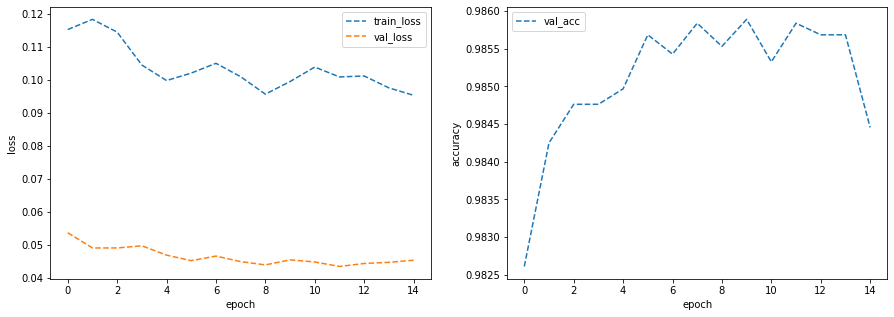

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#epochs = len(history['epoch'])
#x = np.linspace(0, epochs, epochs)

ax[0].plot(history['epoch'], history['train_loss'], label='train_loss', linestyle='--')
ax[0].plot(history['epoch'], history['val_loss'], label='val_loss', linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(history['epoch'], history['val_acc'], label='val_acc', linestyle='--')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

## Visualize Model Output

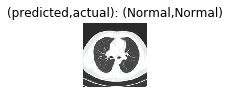

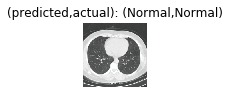

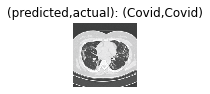

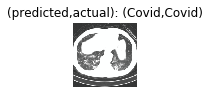

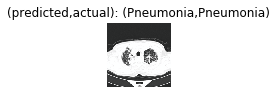

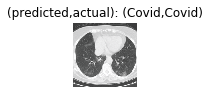

In [21]:
eval_history = visualize_model(model_ft, num_images=6, pred_images=dataset_sizes['test'])

## Evaluation

In [24]:
print(classification_report(eval_history['actual'], eval_history['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.982     0.986     0.984      9335
      Normal      0.978     0.993     0.986      6058
   Pneumonia      0.987     0.955     0.971      4098

    accuracy                          0.982     19491
   macro avg      0.982     0.978     0.980     19491
weighted avg      0.982     0.982     0.982     19491



## Export Weights

In [29]:
torch.save(model_ft.state_dict(), '/home/ubuntu/w251_transfer_learning_weights')

## Test for NX

In [24]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import PIL
import time

In [2]:
# Path of pre-trained model
PATH = '/home/ubuntu/w251_transfer_learning_weights'

In [116]:
# to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pretratined model into resnet18
model_tl = models.resnet18(pretrained=True)
num_ftrs = model_tl.fc.in_features

# Load pretrained weights into FC layer
model_tl.fc = nn.Linear(num_ftrs, 3)
model_tl.load_state_dict(torch.load(PATH))

# Push model to GPU
model_tl = model_tl.to(device)

In [121]:
def prediction(model, image):
    
    # Index for classes
    class_names = ['Covid', 'Normal', 'Pneumonia']
    
    # Put model to evaluation mode
    model.eval()  

    # Transform image for the model
    data_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    inputs = data_transform(image) 
    
    # Make 4D for Resnet: (batch, channel, width, height)
    inputs = inputs.cuda().float().unsqueeze(0)   
    
    # Prediction with model - outputs class and probability
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        prob = nn.functional.softmax(outputs, dim=1)
        
        print(class_names[preds[0]], ': %0.3f' %prob[0][preds[0]].item())

In [125]:
image = os.listdir('/home/ubuntu/data/2A_images_reorg/test/Pneumonia')[300]
image_path = '/home/ubuntu/data/2A_images_reorg/test/Pneumonia/' + image

# Read in image using CV2 and convert to PIL for transformations
img = cv2.imread(image_path)
img = PIL.Image.fromarray(img).convert('RGB')

In [126]:
prediction(model_tl, img)

Pneumonia : 1.000
